In [1]:
%load_ext lab_black

In [2]:
import json
import logging
import math
import os
import random
import shutil
import sys
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

import networks
import utils
from error_list import error_list

---

## 하이퍼 파라미터

In [3]:
POSE_MODEL = "HRNet-W48"
DET_PRETRAINED = ""
RESULT_DIR = Path("results/hrnet+det")

LR = 1e-4  # transfer learning이니깐 좀 작게 주는게 좋을 것 같아서 1e-4
BATCH_SIZE = 1
START_EPOCH = 1
SAM = True
FOLDS = [1, 2, 3, 4, 5]
PADDING = 30

n = datetime.now()
UID = f"{n.year:04d}{n.month:02d}{n.day:02d}-{n.hour:02d}{n.minute:02d}{n.second:02d}"
SEED = 20210309

In [4]:
torch.set_grad_enabled(False)

---

## 데이터셋 준비

In [5]:
total_imgs = np.array(sorted(list(Path("data/ori/train_imgs/").glob("*.jpg"))))
test_imgs = np.array(sorted(list(Path("data/ori/test_imgs/").glob("*.jpg"))))

df = pd.read_csv("data/ori/train_df.csv")
total_keypoints = df.to_numpy()[:, 1:].astype(np.float32)
total_keypoints = np.stack([total_keypoints[:, 0::2], total_keypoints[:, 1::2]], axis=2)

In [6]:
total_imgs_, total_keypoints_ = [], []
for i in range(len(total_imgs)):
    if i not in error_list:
        total_imgs_.append(total_imgs[i])
        total_keypoints_.append(total_keypoints[i])
total_imgs = np.array(total_imgs_)
total_keypoints = np.array(total_keypoints_)

In [67]:
class DetectionDataset(Dataset):
    def __init__(self, files, keypoints=None, augmentation=True, padding=30):
        super().__init__()
        self.files = files
        self.keypoints = keypoints
        self.padding = padding

        T = []
        T.append(A.Crop(0, 28, 1920, 1080 - 28))  # 1920x1080 --> 1920x1024
        T.append(A.Resize(512, 1024))
        if augmentation:
            T.append(A.ImageCompression())
            T.append(A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, value=0, rotate_limit=0))
            T.append(A.HorizontalFlip())
            T.append(A.Cutout())
            T_ = []
            T_.append(A.RandomBrightnessContrast())
            T_.append(A.RandomGamma())
            T_.append(A.RandomBrightness())
            T_.append(A.RandomContrast())
            T.append(A.OneOf(T_))
            T.append(A.GaussNoise())
            T.append(A.Blur())
        T.append(A.Normalize())
        T.append(ToTensorV2())

        if self.keypoints is not None:
            self.transform = A.Compose(T, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]))
        else:
            self.transform = A.Compose(T)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = str(self.files[idx])
        image = imageio.imread(file)

        if self.keypoints is not None:
            box = utils.keypoint2box(self.keypoints[idx], self.padding)
            box = np.expand_dims(box, 0)
            labels = np.array([0], dtype=np.int64)
            a = self.transform(image=image, labels=labels, bboxes=box)

            # Image
            image = a["image"]

            # Annotation
            annot = np.zeros((1, 5), dtype=np.float32)
            annot[0, :4] = a["bboxes"][0]
            annot[0, 4] = 0
            annot = torch.tensor(annot, dtype=torch.float32)

            return file, image, annot
        else:
            a = self.transform(image=image)
            return file, a["image"]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f06336e9710>
Traceback (most recent call last):
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self.

---

## 검증

In [8]:
det_model = networks.EfficientDet("efficientdet-d2", pretrained=True)

In [9]:
det_model.load_state_dict(torch.load("results/det/ckpt-20210318-150954_1.pth")["model"])

<All keys matched successfully>

In [10]:
det_model.eval()
pass

In [68]:
FOLD = 1
kf = KFold(shuffle=True, random_state=SEED)
train_idx, valid_idx = list(kf.split(total_imgs))[FOLD - 1]
train_imgs, valid_imgs = total_imgs[train_idx], total_imgs[valid_idx]
train_keypoints, valid_keypoints = total_keypoints[train_idx], total_keypoints[valid_idx]
ds_train = DetectionDataset(train_imgs, train_keypoints, augmentation=True, padding=PADDING)
ds_valid = DetectionDataset(valid_imgs, valid_keypoints, augmentation=False, padding=PADDING)
ds_test = DetectionDataset(test_imgs, augmentation=False, padding=PADDING)
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

### 예제 1 - validation

In [12]:
for imgs, annots in dl_valid:
    break

In [13]:
out = det_model(imgs)

In [14]:
out[0]

{'rois': array([[ 464.77313,  157.73653,  621.98126,  453.72046],
        [ 776.85974,  208.44998,  826.3943 ,  343.33932],
        [ 903.18604,  315.1587 , 1023.     ,  399.75336]], dtype=float32),
 'class_ids': array([0, 0, 0]),
 'scores': array([0.9959335 , 0.71259236, 0.20047851], dtype=float32)}

In [31]:
out[0]["rois"][0]

array([464.77313, 157.73653, 621.98126, 453.72046], dtype=float32)

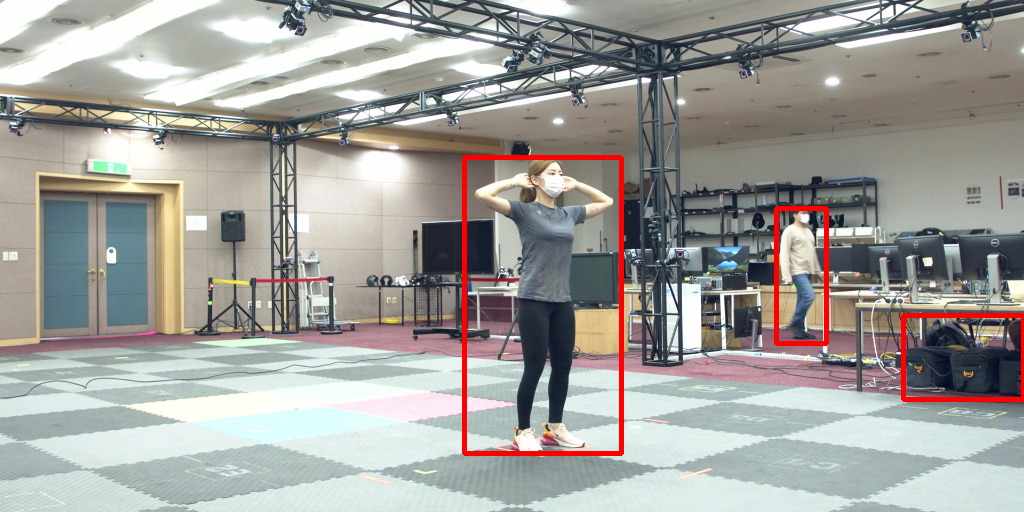

In [39]:
img_np = utils.denormalize(imgs[0]).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))

for bbox in out[0]["rois"]:
    bbox = bbox.astype(np.int64)
    cv2.rectangle(img_np, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 3)
Image.fromarray(img_np)

### 예제 2 - test

In [42]:
for imgs in dl_test:
    break

In [43]:
out = det_model(imgs)

In [44]:
out[0]

{'rois': array([[350.42633, 118.10448, 637.88025, 357.05255]], dtype=float32),
 'class_ids': array([0]),
 'scores': array([0.9983662], dtype=float32)}

In [45]:
out[0]["rois"][0]

array([350.42633, 118.10448, 637.88025, 357.05255], dtype=float32)

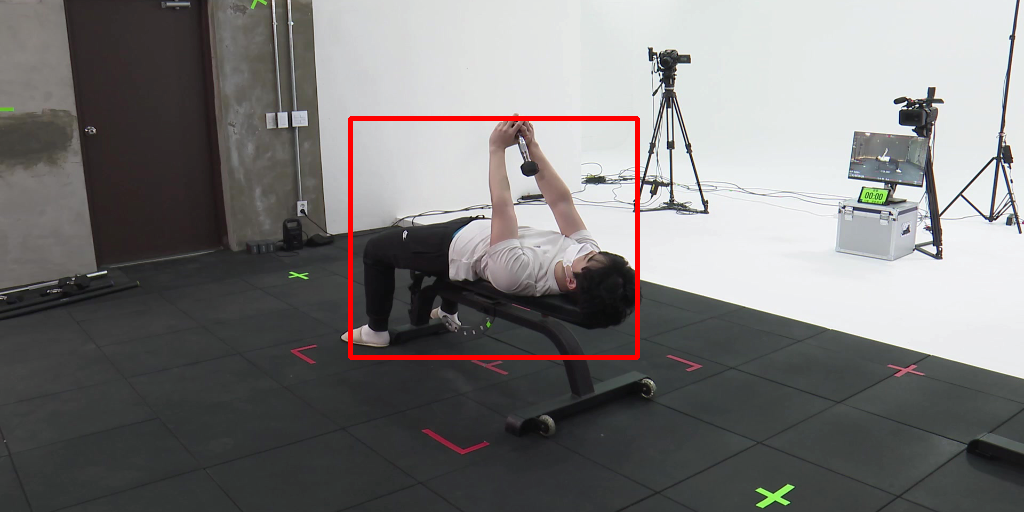

In [46]:
img_np = utils.denormalize(imgs[0]).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))

for bbox in out[0]["rois"]:
    bbox = bbox.astype(np.int64)
    cv2.rectangle(img_np, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 3)
Image.fromarray(img_np)

---

## 데이터 만들기

일단 TTA를 생각하지는 말고, 이미지를 자르고 keypoint + offset을 저장한다.

---

TTA를 할게 아니라면 굳이 det과 pose를 합지지는 않아도 된다.

TTA를 할 때 가장 우려되는 점이 augmentation을 거친 annotation을 어떻게 다시 원본으로 되돌릴까에 대한 문제이다.

geometric transform만 제외하고 나머지 transform만 적용하는 방법?

In [54]:
def get_roi(out):
    rois = out["rois"]
    class_ids = out["class_ids"]
    scores = out["scores"]

    rois = rois[class_ids == 0]
    scores = scores[class_ids == 0]
    roi = rois[np.argmax(scores)]
    return roi

In [50]:
det_model = det_model.cuda()

In [56]:
outdir = Path("data/test_imgs_effdet")
outdir.mkdir(parents=True, exist_ok=True)

In [77]:
data = {"offset": [], "ratio": []}
with tqdm(total=len(dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for files, imgs in dl_test:
        outs = det_model(imgs.cuda())
        for file, img, out in zip(files, imgs, outs):
            file = Path(file)
            t.set_postfix_str(file.name)

            roi = get_roi(out).astype(np.int64)
            img_np = utils.denormalize(img).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
            img_roi = img_np[roi[1] : roi[3], roi[0] : roi[2]]

            data["offset"].append((int(roi[0]), int(roi[1])))
            data["ratio"].append((288 / img_roi.shape[1], 384 / img_roi.shape[0]))

            img_resize = cv2.resize(img_roi, (288, 384))
            imageio.imwrite(outdir / file.name, img_resize)

            t.update()

with open(outdir / "data.json", "w") as f:
    json.dump(data, f)

100%|█████████████████████████████| 1600/1600 [01:23<00:00, 19.27it/s, 786-3-5-41-Z94_E-0000031.jpg]
